# 🌡️ Daily Average Temperature Forecasting using ARIMA

This notebook demonstrates classical time series forecasting of **daily average temperature** using the **ARIMA** model.

We follow these main steps:

- Load and prepare the temperature dataset
- Explore and visualize temperature trends
- Check and enforce stationarity of the time series
- Identify the optimal ARIMA model order (p, d, q)
- Fit and evaluate the ARIMA model
- Forecast future temperatures and visualize predictions

The dataset covers daily average temperatures in **New York City** from **January 2000 to January 2025**, retrieved using the **Meteostat** library.

## 📥 Step 1: Load and Prepare the Dataset

We load the historical data, clean and format it, and set the `time` column as the index for time series analysis.

In [27]:
# 📚 Libraries Import

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

# Time series and statistical modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Auto ARIMA for order selection
from pmdarima import auto_arima

# Metrics for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('../data/new_york_daily_avg_temp_2005_2025.csv')
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df.set_index('time', inplace=True)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9133 entries, 2000-01-01 to 2025-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    9133 non-null   float64
dtypes: float64(1)
memory usage: 142.7 KB


,tavg
time,
2000-01-01,5.0
2000-01-02,9.4
2000-01-03,14.4
2000-01-04,14.4
2000-01-05,3.9
2000-01-06,1.1
2000-01-07,5.6
2000-01-08,1.1
2000-01-09,6.1


## 📊 Step 2: Visualize the Raw Daily Average Temperature

We plot the raw daily average temperature to observe overall trends, seasonality, and any patterns over time.

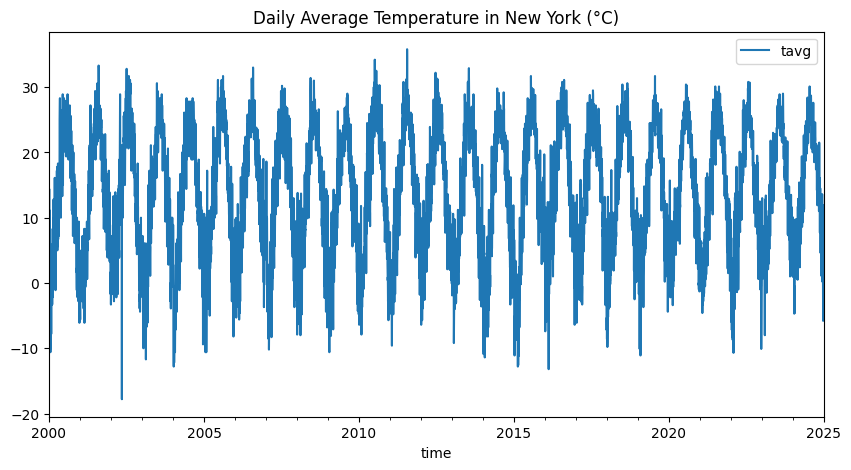

In [29]:
df.plot(figsize=(10,5))
plt.title('Daily Average Temperature in New York (°C)')
plt.show()

## 🔄 Step 3: Ensure Data is at Daily Frequency

Resample the temperature dataset to daily frequency using mean aggregation to handle any missing days and smooth the time series.

In [30]:
df_day = df.resample('D').mean()
print('Count of the daily temperature records : ', df_day.shape[0])
df_day.info()
df_day = df_day.dropna()

Count of the daily temperature records :  9133
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9133 entries, 2000-01-01 to 2025-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tavg    9133 non-null   float64
dtypes: float64(1)
memory usage: 142.7 KB


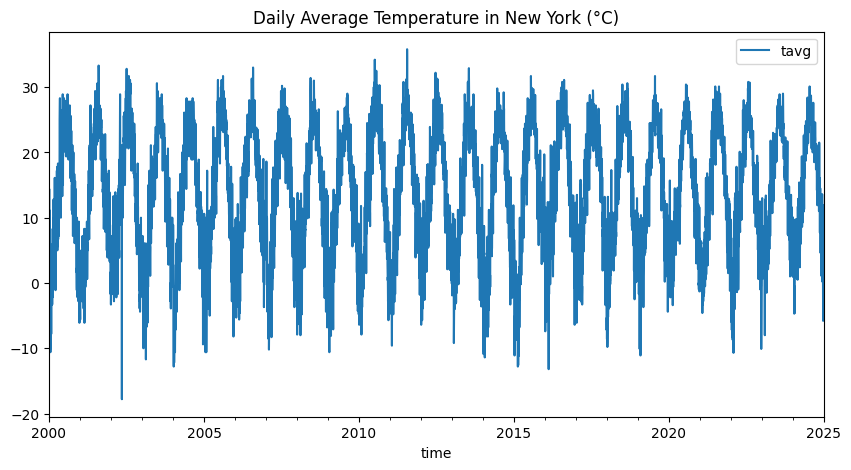

In [31]:
df_day.plot(figsize=(10,5))
plt.title('Daily Average Temperature in New York (°C)')
plt.show()

## 📈 Step 4: Distribution Analysis of Daily Average Temperature

Examine the distribution of daily average temperature using histogram and kernel density estimation to understand variability and patterns.

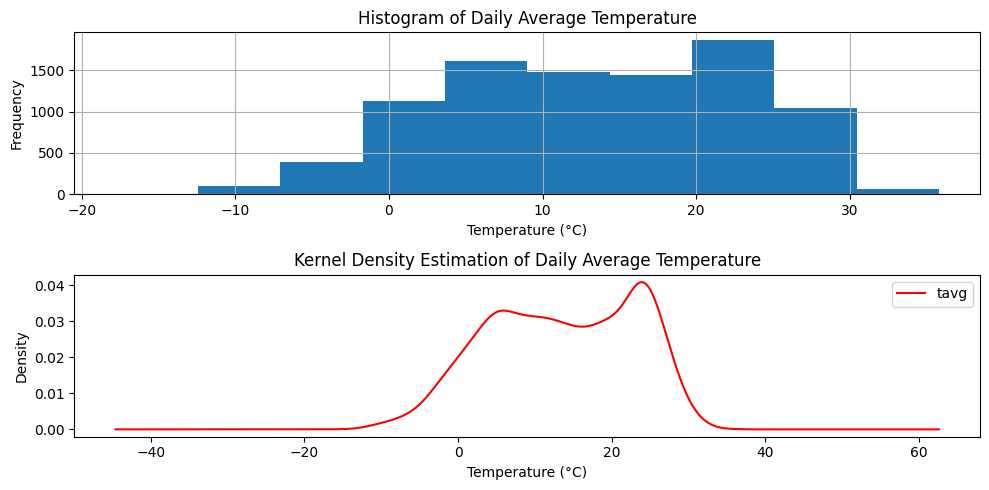

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

df_day.hist(ax=ax1)
ax1.set_title('Histogram of Daily Average Temperature')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Frequency')

df_day.plot(kind='kde', ax=ax2, color='r')
ax2.set_title('Kernel Density Estimation of Daily Average Temperature')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.show()

## 🔍 Step 5: Time Series Decomposition

Decompose the daily average temperature series into trend, seasonal, and residual components to explore underlying patterns and seasonality.

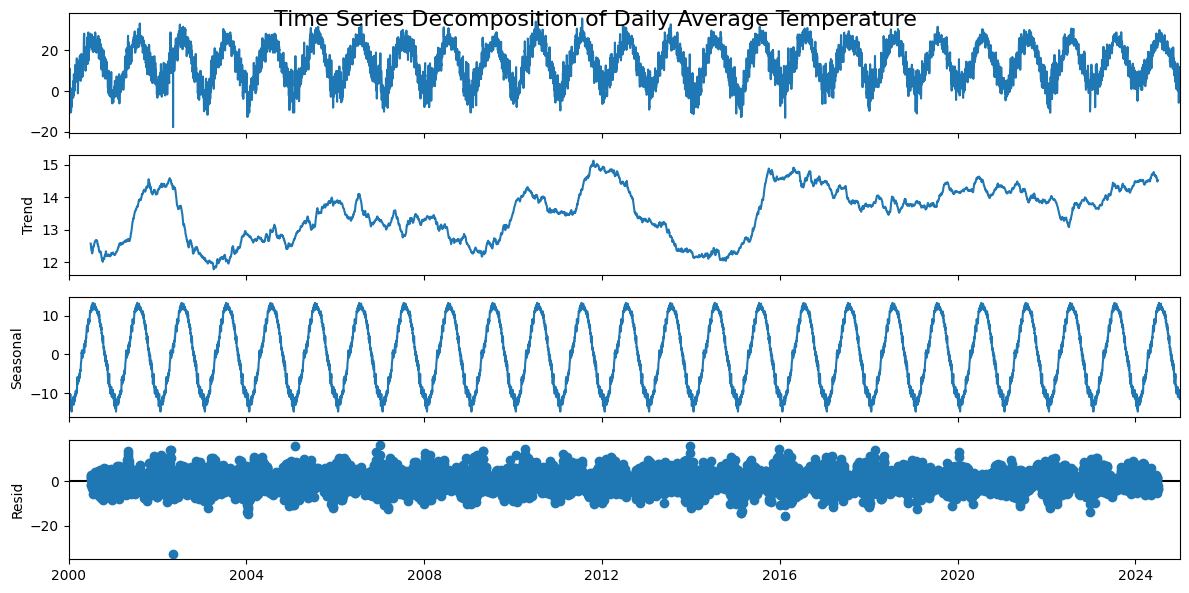

In [33]:
plt.rcParams['figure.figsize'] = (12, 6)

# Decompose the daily average temperature into trend, seasonal, and residual components
decomposition = seasonal_decompose(df_day, period=365, model='additive')

decomposition.plot()
plt.suptitle('Time Series Decomposition of Daily Average Temperature', fontsize=16)
plt.show()

## 📉 Step 6: Autocorrelation and Partial Autocorrelation Plots

Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to help identify the AR (autoregressive) and MA (moving average) terms for the ARIMA model applied to the temperature series.

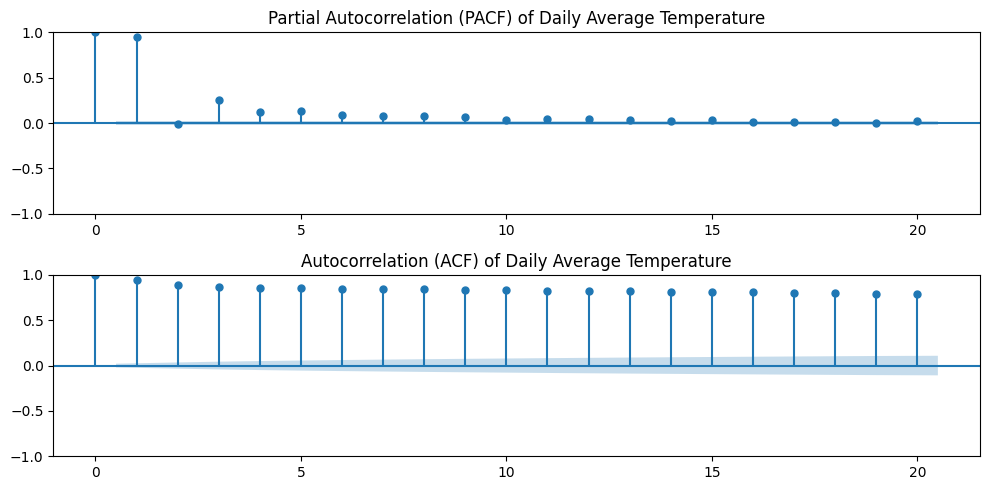

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

plot_pacf(df_day, lags=20, ax=ax1)
ax1.set_title('Partial Autocorrelation (PACF) of Daily Average Temperature')

plot_acf(df_day, lags=20, ax=ax2)
ax2.set_title('Autocorrelation (ACF) of Daily Average Temperature')

plt.tight_layout()
plt.show()

## 🧪 Step 7: Stationarity Test Using Augmented Dickey-Fuller (ADF) Test

Check if the daily average temperature series is stationary. If not, we will apply differencing to stabilize the mean and make it stationary.

In [35]:
def adf_check(time_series):
    """
    Perform Augmented Dickey-Fuller test to check stationarity of the temperature series.
    
    Parameters:
    time_series (pd.Series): The time series data to test.
    
    Prints the test statistic, p-value, critical values, and interpretation.
    """
    result = adfuller(time_series, autolag='AIC')
    label = pd.Series(result[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    
    for key, value in result[4].items():
        label[f'Critical Value ({key})'] = value
    
    print(label)
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis. Reject null hypothesis: the series is Stationary.')
    else:
        print('Weak evidence against the null hypothesis. Fail to reject null hypothesis: the series is Not Stationary.')

In [36]:
adf_check(df_day['tavg'])

Test Statistic                -6.785785e+00
p-value                        2.434256e-09
Number of Lags Used            3.700000e+01
Number of Observations Used    9.095000e+03
Critical Value (1%)           -3.431069e+00
Critical Value (5%)           -2.861858e+00
Critical Value (10%)          -2.566939e+00
dtype: float64
Strong evidence against the null hypothesis. Reject null hypothesis: the series is Stationary.


## 🔍 Step 8: Identify ARIMA Model Order Using `auto_arima`

Use `auto_arima` to automatically select the best ARIMA model order (p, d, q) for the daily average temperature series based on the Akaike Information Criterion (AIC).

In [37]:
model = auto_arima(df_day['tavg'], seasonal=False, m=52, d=0, max_order=8, test='adf', trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=45550.055, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=77196.615, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=46908.258, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=66486.578, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=45784.770, Time=0.57 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=46784.778, Time=0.76 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=45543.438, Time=1.78 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=45578.016, Time=1.09 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=45572.845, Time=2.76 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=45547.735, Time=1.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=45544.044, Time=1.44 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=45553.006, Time=1.42 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=45545.310, Time=1.37 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=45527.191, Time=2.99 sec
 ARIMA(2,0,2)(0,0,0

In [38]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9133
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -22756.595
Date:                Sat, 02 Aug 2025   AIC                          45527.191
Time:                        17:47:15   BIC                          45577.028
Sample:                    01-01-2000   HQIC                         45544.137
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0488      0.012      4.241      0.000       0.026       0.071
ar.L1          1.4037      0.037     38.304      0.000       1.332       1.476
ar.L2         -0.4608      0.064     -7.246      0.0

## 🔨 Step 9: Fit ARIMA Model

Fit the selected ARIMA model (3,0,2) and visualize diagnostic plots.

In [39]:
model = ARIMA(df_day['tavg'], order=(3,0,2))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   tavg   No. Observations:                 9133
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -22756.607
Date:                Sat, 02 Aug 2025   AIC                          45527.213
Time:                        17:47:19   BIC                          45577.051
Sample:                    01-01-2000   HQIC                         45544.159
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.5117      1.876      7.202      0.000       9.835      17.189
ar.L1          1.4038      0.037     38.308      0.000       1.332       1.476
ar.L2         -0.4610      0.064     -7.249      0.000      -0.586      -0.336
ar.L3          0.0535      0.029      1.823      0.068      -0.004       0.111
ma.L1         -0.5262      0.037    -14.351      0.000      -0.598      -0.454
ma.L2         -0.2634      0.035     -7.443      0.000      -0.333      -0.194
sigma2         8.5436      0.081    106.029      0.000       8.386       8.702
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6840.69
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

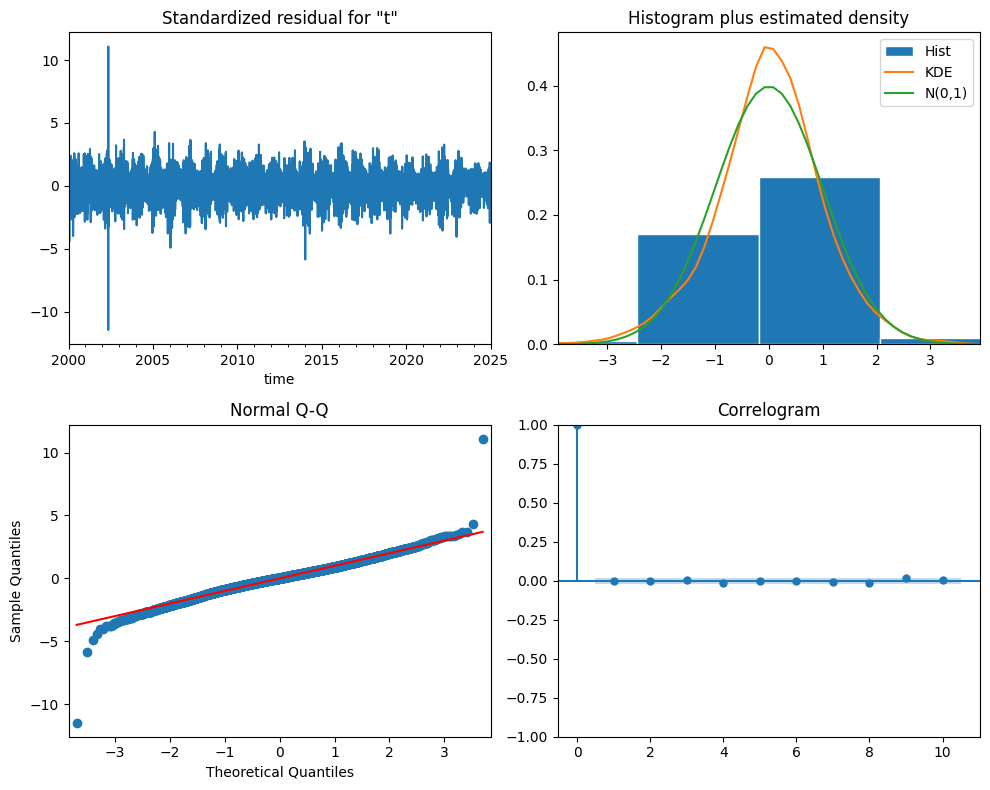

In [40]:
result.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

## 🚦 Step 10: Train-Test Split

Split data into training (90%) and testing (10%) sets for model evaluation.


In [41]:
size = int(len(df_day)*0.90)
train = df_day['tavg'][:size]
test = df_day['tavg'][size:]

print(f'Train size: {len(train)}')
print(f'Test size: {len(test)}')

Train size: 8219
Test size: 914


## 📊 Step 11: Train ARIMA Model on Training Data and Forecast

Fit the ARIMA model on the training portion of the daily average temperature data and forecast temperatures over the entire test set.

In [42]:
# Convert training data to list
train_values = train.tolist()

# Fit ARIMA model on training temperature data
model = ARIMA(train_values, order=(3,0,2), enforce_stationarity=False)
model_fit = model.fit()

# Forecast temperature for the length of the test set
forecast = model_fit.forecast(steps=len(test))
print(forecast)

[25.72725009 24.53986832 24.10345004 23.95648044 23.88366724 23.82396826
 23.76533742 23.70655298 23.6478548  23.58941784 23.53129889 23.47350951
 23.41604979 23.35891781 23.30211159 23.2456292  23.1894688  23.13362853
 23.07810659 23.02290114 22.96801039 22.91343255 22.85916583 22.80520846
 22.75155866 22.6982147  22.64517483 22.59243731 22.54000042 22.48786244
 22.43602168 22.38447643 22.33322502 22.28226577 22.23159701 22.18121708
 22.13112435 22.08131717 22.03179391 21.98255296 21.93359271 21.88491156
 21.83650791 21.78838019 21.74052682 21.69294624 21.64563689 21.59859722
 21.55182571 21.50532081 21.45908102 21.41310482 21.3673907  21.32193718
 21.27674276 21.23180597 21.18712535 21.14269943 21.09852675 21.05460589
 21.01093539 20.96751384 20.92433981 20.88141189 20.83872869 20.7962888
 20.75409083 20.71213342 20.67041519 20.62893476 20.5876908  20.54668195
 20.50590687 20.46536423 20.4250527  20.38497096 20.34511772 20.30549165
 20.26609147 20.2269159  20.18796364 20.14923343 20.

## 🔄 Step 12: Step-wise Forecasting with Model Updating

Perform one-step-ahead forecasts for the daily average temperature series, updating the training set with actual observed values after each prediction to improve accuracy.

In [43]:
prediction = []
history = train_values.copy()

for t in range(len(test)):
    model = ARIMA(history, order=(3,0,2), enforce_stationarity=False)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(float(yhat))
    history.append(test.iloc[t])
    print(f'Predicted = {yhat:.4f}, Actual = {test.iloc[t]:.4f}')

Predicted = 25.7273, Actual = 26.8000
Predicted = 25.4778, Actual = 25.0000
Predicted = 24.2279, Actual = 24.5000
Predicted = 24.3366, Actual = 26.7000
Predicted = 26.2566, Actual = 24.6000
Predicted = 23.8441, Actual = 23.1000
Predicted = 23.3905, Actual = 25.1000
Predicted = 25.2443, Actual = 23.7000
Predicted = 23.3571, Actual = 23.3000
Predicted = 23.6070, Actual = 26.0000
Predicted = 25.8278, Actual = 27.6000
Predicted = 26.4873, Actual = 27.2000
Predicted = 26.0537, Actual = 25.8000
Predicted = 25.1548, Actual = 24.9000
Predicted = 24.7723, Actual = 25.6000
Predicted = 25.5212, Actual = 26.6000
Predicted = 26.1344, Actual = 28.5000
Predicted = 27.6270, Actual = 29.8000
Predicted = 28.4000, Actual = 29.4000
Predicted = 28.0078, Actual = 29.8000
Predicted = 28.7138, Actual = 30.0000
Predicted = 28.8558, Actual = 30.8000
Predicted = 29.6868, Actual = 28.1000
Predicted = 27.2380, Actual = 25.8000
Predicted = 26.1399, Actual = 25.9000
Predicted = 26.5316, Actual = 26.7000
Predicted = 

## 📈 Step 13: Plot Actual vs Predicted Daily Average Temperatures

Visualize how well the ARIMA model forecasts daily average temperatures on the test set.

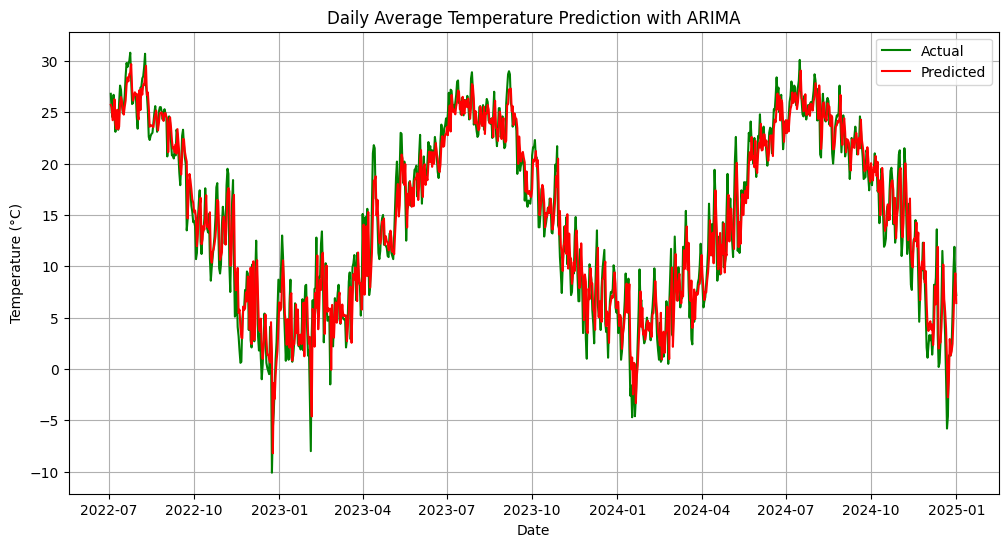

In [44]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual', color='g')
plt.plot(test.index, prediction, label='Predicted', color='r')
plt.title('Daily Average Temperature Prediction with ARIMA')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.show()

## 🧮 Step 16: Evaluate Forecast Performance

We compute the following evaluation metrics:
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)
- R² (The R-squared score)
- Precision = R² * 100

In [45]:
mae = mean_absolute_error(test, prediction)
mse = mean_squared_error(test, prediction)
rmse = np.sqrt(mse)
r2 = r2_score(test, prediction)
precision = r2 * 100

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'The R-squared score (R²): {r2:.4f}')
print(f'Precision: {precision:.2f}%')

Mean Absolute Error (MAE): 1.8234
Mean Squared Error (MSE): 5.6653
Root Mean Squared Error (RMSE): 2.3802
The R-squared score (R²): 0.9226
Precision: 92.26%
